# Fig 2: plot coarse labels
### DANDI-set: [000055](https://dandiarchive.org/dandiset/000055/draft)
### Notebook author: Steven Peterson

In [ ]:
%pip install --no-deps ndx-events

In [ ]:
import pdb
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO
from ndx_events import LabeledEvents, AnnotatedEventsTable, Events

In [ ]:
def get_data_location(dandiset_id, filepath, s3=False):
    """Get the location for any NWB file on DANDI"""
    
    asset_id = requests.request(
        "GET",
        f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/",
        headers={"Accept": "application/json"},
        params={"path": filepath},
    ).json()['results'][0]['asset_id']
    
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/{asset_id}/download/"
    if not s3:
        return url
    
    s3_url = requests.request(url=url, method='head').url
    if '?' in s3_url:
        return s3_url[:s3_url.index('?')]
    return s3_url

In [ ]:
targ_tlims = [13, 17]  # targeted window to plot (in hours)
targeted = False  # plot targeted window (True) or whole day (False)
first_val = True  # for targeted window, plot first activity label (True) or second (False)

In [ ]:
dandiset_id = '000055'
fname = 'sub-01/sub-01_ses-4_behavior+ecephys.nwb'

s3_path = get_data_location(dandiset_id, fname, s3=True)


io = NWBHDF5IO(s3_path, mode='r', load_namespaces=False, driver='ros3')
nwb = io.read()
clabels_orig = nwb.intervals['epochs'].to_dataframe()

In [ ]:
clabels = clabels_orig.copy()
if not targeted:
    for i in range(len(clabels_orig)):
        lab = clabels_orig.loc[i, 'labels']
        if lab[:5] == 'Block':
            clabels.loc[i, 'labels'] = 'Blocklist'
        elif lab == '':
            clabels.loc[i, 'labels'] = 'Blocklist'
        elif lab not in ['Sleep/rest', 'Inactive']:
            clabels.loc[i, 'labels'] = 'Active'
else:
    for i in range(len(clabels_orig)):
        lab = clabels_orig.loc[i, 'labels']
        if lab[:5] == 'Block':
            clabels.loc[i, 'labels'] = 'Blocklist'
        elif lab == '':
            clabels.loc[i, 'labels'] = 'Blocklist'
        elif first_val:
            clabels.loc[i, 'labels'] = lab.split(', ')[0]
        else:
            clabels.loc[i, 'labels'] = lab.split(', ')[-1]

if targeted:
    start_val, end_val = targ_tlims[0]*3600, targ_tlims[1]*3600
    clabels = clabels[(clabels['start_time'] >= start_val) &\
                      (clabels['stop_time'] <= end_val)]
    clabels.reset_index(inplace=True)
uni_labs = np.unique(clabels['labels'].values)

## Plot labels over time

In [ ]:
act_cols = plt.get_cmap('Reds')(np.linspace(0.15, 0.85, 5))
if targeted:
    if first_val:
        category_colors = np.array(['dimgray', act_cols[1], act_cols[2],
                                    act_cols[0], act_cols[3], act_cols[4]],
                                   dtype=object)
    else:
        category_colors = np.array(['dimgray', act_cols[1], act_cols[0],
                                    act_cols[3], act_cols[4]],
                                   dtype=object)
else:
    category_colors = np.array([[1, 128/255, 178/255],'dimgray','lightgreen','lightskyblue'],
                               dtype=object)
    
scale_fact = 1/3600
bwidth = 0.5
fig, ax = plt.subplots(figsize=(20, 2), dpi=150)
for i in range(len(uni_labs)):
    lab_inds = np.nonzero(uni_labs[i] == clabels['labels'].values)[0]
    lab_starts = clabels.loc[lab_inds, 'start_time'].values
    lab_stops = clabels.loc[lab_inds, 'stop_time'].values
    lab_widths = lab_stops - lab_starts
    rects = ax.barh(np.ones_like(lab_widths), lab_widths*scale_fact, left=lab_starts*scale_fact,
                    height=bwidth, label=uni_labs[i], color=category_colors[i])
    
ax.legend(ncol=len(uni_labs), bbox_to_anchor=(0, 1),
          loc='lower left', fontsize='small')

if targeted:
    plt.xlim(targ_tlims)
    targ_tlims_int = [int(val) for val in targ_tlims]
    plt.xticks(targ_tlims_int)
    ax.set_xticklabels(['{}:00'.format(targ_tlims_int[0]),
                        '{}:00'.format(targ_tlims_int[-1])])
else:
    plt.xlim([0, 24])
    plt.xticks([0, 12, 24])
    ax.set_xticklabels(['0:00', '12:00', '0:00'])

ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [1]:
import pynwb

In [3]:
nwb = pynwb.NWBHDF5IO('/Users/bendichter/Downloads/sub-anm369962_ses-20170309.nwb','r').read()

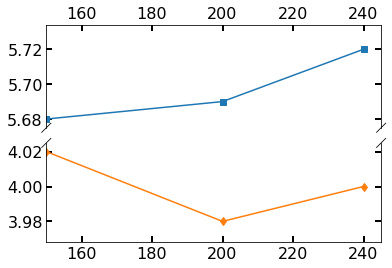

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from brokenaxes import brokenaxes
fig = plt.figure()

x,y1,y2 = [150,200,240],[5.68, 5.69, 5.72],[4.02,3.98,4.00]

bax = brokenaxes(ylims=((3.968,4.025),(5.675,5.734)), hspace=.15, despine=False)

bax.plot(x,y1,marker='s')
bax.plot(x,y2,marker='d')

bax.tick_params(axis = 'both', labelsize=16, length=6, width=2, direction='in')


bax.set_xlim([150,245])

for ax in bax.axs:
    subplot_spec = ax.get_subplotspec()
    if  subplot_spec.is_first_row():
        if subplot_spec.is_last_row():
            ax.xaxis.set_ticks_position('both')
        else:
            ax.xaxis.set_ticks_position('top')
    if subplot_spec.is_last_col():
        if subplot_spec.is_first_col():
            ax.yaxis.set_ticks_position('both')
        else:
            ax.yaxis.set_ticks_position('right')

In [17]:
aa =

In [18]:
aa

True